<a href="https://colab.research.google.com/github/sdannels/synthetic_time_series_forecasting/blob/main/synthetic_forecasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install torch numpy pandas matplotlib scikit-learn fredapi statsmodels datetime keras math

In [2]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import datetime as dt
import torch
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import load_model
#from gretel_synthetics.timeseries_dgan.dgan import DGAN
#from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
# read in economic data and convert to DateTime index
df = pd.read_csv("/content/drive/MyDrive/Synthetic_data/fred_data", index_col = 0)
df.index = pd.DatetimeIndex(df.index)
df.index.name = 'date'
df = df.reset_index()
# create lag of 1 and 10-year yield
df['DGS1_lag'] = df['DGS1'].shift(1)
df['DGS10_lag'] = df['DGS10'].shift(1)

In [4]:
# function to plot forecasting results
def plot_forecast_compare(compare_df, forecast_var_name, actual_var_name, title,
                          RMSE = True, MAPE = True):
  """
  compare_df is dataframe with forecasted, actual, and date values
  forecast_var_name, actual_var_name are strings for column names in compare_df
  title is a string for the title of the graph
  RMSE and MAPE: True if want to output those statistics above graph
  """
  # print RMSE
  if RMSE == True:
    model_rmse = math.sqrt(mean_squared_error(compare_df[actual_var_name], compare_df[forecast_var_name]))
    print(f'RMSE: {model_rmse}')
  
  # print MAPE
  if MAPE == True:
    model_mape = mean_absolute_percentage_error(compare_df[actual_var_name], compare_df[forecast_var_name])*100
    print(f'MAPE: {model_mape}')

  # plot results
  plt.plot(compare_df['date'], compare_df[actual_var_name], label = 'Actual')
  plt.plot(compare_df['date'], compare_df[forecast_var_name], label = 'Forecast')
  plt.title(title)
  plt.legend()
  plt.xticks(rotation = 45)
  plt.show()

# Autoregressive Model

In [16]:
# set last date for training data and first date for forecasting (next day)
last_train_date = '12-31-2016'
start_forecast_date = dt.datetime.strptime(last_train_date, '%m-%d-%Y') + dt.timedelta(days = 3)
start_forecast_date = start_forecast_date.strftime('%m-%d-%Y')
end_forecast_date = '01-11-2023'

# split up training and testing data
train_df = df[df['date'] <= last_train_date]
test_df = df[df['date'] > last_train_date]

## 1-year Treasury Yield

In [17]:
# choose optimal number of lags by BIC
opt_mod = ar_select_order(train_df['DGS1'], exog = train_df['DGS10_lag'], 
                          maxlag=15, ic = 'bic', missing = 'drop', old_names = False)
print(f'Chosen lags: {opt_mod.ar_lags}')
# fit model with chosen number of lags and heteroskedastic-robust standard errors
mod = AutoReg(train_df['DGS1'], exog = train_df['DGS10_lag'], lags = 13, trend = 'c',
              missing = 'drop', old_names = False)
res = mod.fit(cov_type="HC0")
print(res.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Chosen lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
                            AutoReg Model Results                             
Dep. Variable:                   DGS1   No. Observations:                13734
Model:                  AutoReg-X(13)   Log Likelihood               14775.944
Method:               Conditional MLE   S.D. of innovations              0.082
Date:                Mon, 16 Jan 2023   AIC                             -4.989
Time:                        20:56:36   BIC                             -4.981
Sample:                            13   HQIC                            -4.986
                                13734                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.325      0.745      -0.004       0.005
DGS1.L1        1.1031      0.021     51.607      0.000       1.061       1.14

In [18]:
# find start and end index numbers
df_index = df.copy()
start_forecast_index = df_index.index[df_index['date'] == start_forecast_date][0]
end_forecast_index = df_index.index[df_index['date'] == end_forecast_date][0]
del df_index

# forecast
ar_preds = res.predict(start = start_forecast_index, end = end_forecast_index, 
                       exog_oos = test_df['DGS10_lag'], dynamic = False)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


RMSE: 1.2093689916881336
MAPE: 535.1963216815966


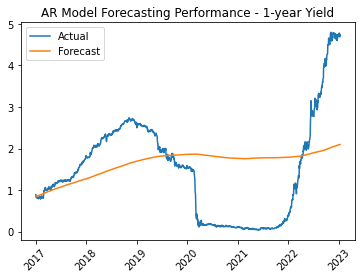

In [19]:
# compare forecasts to actuals
actuals = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), 'DGS1']
actuals_df = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), ['date', 'DGS1']]
ar_compare = pd.concat([actuals_df, ar_preds], axis = 1)
ar_compare.columns = ['date', 'actual', 'forecast']

plot_forecast_compare(ar_compare,
                      forecast_var_name = 'forecast', actual_var_name = 'actual',
                      title = 'AR Model Forecasting Performance - 1-year Yield')

## 10-year Treasury Yield

In [20]:
# choose optimal number of lags by BIC
opt_mod10 = ar_select_order(train_df['DGS10'], exog = train_df['DGS1_lag'], 
                          maxlag=15, ic = 'bic', missing = 'drop', old_names = False)
print(f'Chosen lags: {opt_mod10.ar_lags}')
# fit model with chosen number of lags and heteroskedastic-robust standard errors
mod10 = AutoReg(train_df['DGS10'], exog = train_df['DGS1_lag'], lags = 2, trend = 'c',
              missing = 'drop', old_names = False)
res10 = mod10.fit(cov_type="HC0")
print(res10.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Chosen lags: [1 2]
                            AutoReg Model Results                             
Dep. Variable:                  DGS10   No. Observations:                13734
Model:                   AutoReg-X(2)   Log Likelihood               17774.416
Method:               Conditional MLE   S.D. of innovations              0.066
Date:                Mon, 16 Jan 2023   AIC                             -5.426
Time:                        20:56:56   BIC                             -5.423
Sample:                             2   HQIC                            -5.425
                                13734                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.203      0.028       0.000       0.008
DGS10.L1       1.0685      0.015     70.076      0.000       1.039       1.098
DGS10.L2      -0.0703      0.015 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [21]:
# forecast
ar_preds_10 = res10.predict(start = start_forecast_index, end = end_forecast_index, 
                            exog_oos = test_df['DGS1_lag'], dynamic = False)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


RMSE: 1.3037903165314702
MAPE: 85.31142329159722


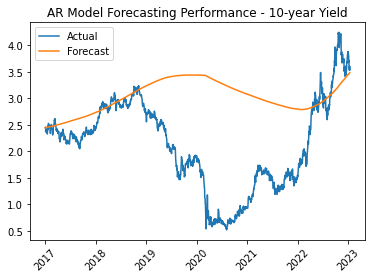

In [22]:
# compare forecasts to actuals
actuals_df10 = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), ['date', 'DGS10']]
ar_compare10 = pd.concat([actuals_df10, ar_preds_10], axis = 1)
ar_compare10.columns = ['date', 'actual', 'forecast']

plot_forecast_compare(ar_compare10,
                      forecast_var_name = 'forecast', actual_var_name = 'actual',
                      title = 'AR Model Forecasting Performance - 10-year Yield')

# LSTM Neural Network (Real Data)

Parts of code adapted from examples in: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [23]:
# function to reformat data from df to numpy array
def df_to_np(df, cols):
  """
    df: pandas DataFrame
    cols = list of column names from df to include
  """
  data = df[cols]
  data = data.to_numpy()
  return data

# function to split data into samples for NN
def split_NN_samples(data, n_steps):
  X, y = list(), list()
  for i in range(len(data)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(data)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = data[i:end_ix, :], data[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [24]:
# select features from df and # of steps for each sample
feature_cols = ['DGS1', 'DGS10']
n_steps = 25

# format training data
train_data = df_to_np(train_df, feature_cols)
train_x, train_y = split_NN_samples(data = train_data, n_steps = n_steps)
# train_x shape is (# of samples, # of steps, # of features)
print(train_x.shape)
n_features = train_x.shape[2]
# train_y shape is (# of samples, # of features)
print(train_y.shape)

(13710, 25, 2)
(13710, 2)


In [25]:
# define model
LSTM_model = Sequential()
LSTM_model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
LSTM_model.add(LSTM(100, activation='tanh'))
LSTM_model.add(Dense(n_features))
LSTM_model.compile(optimizer='adam', loss='mse')

In [26]:
# if true, load a pretrained model instead of training
load_pretrain = True

if load_pretrain == True:
  LSTM_model = load_model("/content/drive/MyDrive/Synthetic_data/LSTM_model")
else:
  # train model
  LSTM_model.fit(train_x, train_y, epochs = 200, verbose = 0)

In [26]:
# save model after training
LSTM_model.save("/content/drive/MyDrive/Synthetic_data/LSTM_model")

In [27]:
# format test data
test_df = df[(df['date'] > last_train_date) & (df['date'] <= end_forecast_date)]
test_data = df_to_np(test_df, feature_cols)
test_x, test_y = split_NN_samples(data = test_data, n_steps = n_steps)
# test_x shape is (# of samples, # of steps, # of features)
print(test_x.shape)
# test_y shape is (# of samples, # of features)
print(test_y.shape)

(1482, 25, 2)
(1482, 2)


In [28]:
# forecast on test data
yhat = LSTM_model.predict(test_x, verbose=0)

RMSE: 0.07851756448877796
MAPE: 18.482230793690942


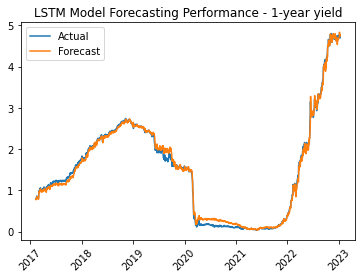

RMSE: 0.17300571794992278
MAPE: 10.673746417769872


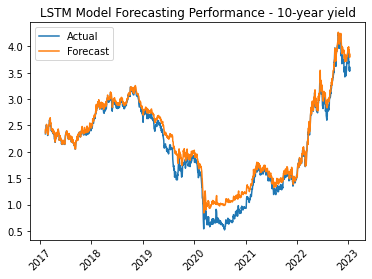

In [29]:
# format dates for comparison
date_compare = test_df['date'].reset_index(drop = True)
date_compare = date_compare[n_steps:].reset_index(drop = True)

# create dataframe for comparing forecasts to actual
LSTM_compare = pd.concat([pd.DataFrame(yhat), pd.DataFrame(test_y)], axis = 1)
LSTM_compare = pd.concat([date_compare, LSTM_compare], axis = 1)
LSTM_compare.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']

# plot results
plot_forecast_compare(LSTM_compare, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = 'LSTM Model Forecasting Performance - 1-year yield')

plot_forecast_compare(LSTM_compare, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = 'LSTM Model Forecasting Performance - 10-year yield')

# LSTM Neural Network (Synthetic Data)

This model is trained on synthetic data, but tested on the same real data as above.

In [30]:
# load previously trained model
#if torch.cuda.is_available() == True:
#  model = DGAN.load('/content/drive/MyDrive/Models/DGAN_trained.pt')
#else:
#  model = DGAN.load('/content/drive/MyDrive/Models/DGAN_trained.pt', map_location = torch.device('cpu'))

# generate synthetic data in numpy array format
# synthetic_attributes, synthetic_features = model.generate_numpy(1000)

# load synthetic data from DGAN_generation notebook
synthetic_features = np.loadtxt("/content/drive/MyDrive/Synthetic_data/synthetic_features_reshaped")
### WARNING: ENSURE THAT SHAPE OF DATA HAS NOT CHANGED IN DGAN_Generation NOTEBOOK ###############
synthetic_features = synthetic_features.reshape(1000, 125, 2)
synthetic_attributes = np.loadtxt("/content/drive/MyDrive/Synthetic_data/synthetic_attributes")
synthetic_attributes = synthetic_attributes.reshape(-1, 1)

In [31]:
# iterate through synthetic samples and split into training data
for i in range(synthetic_features.shape[0]):
  synth_train_x_iter, synth_train_y_iter = split_NN_samples(data = synthetic_features[i, :, :], n_steps = n_steps)
  # start with first sample and then append each array after that
  if i == 0:
    synth_train_x, synth_train_y = synth_train_x_iter, synth_train_y_iter
  else:
    synth_train_x = np.concatenate([synth_train_x, synth_train_x_iter], axis = 0)
    synth_train_y = np.concatenate([synth_train_y, synth_train_y_iter], axis = 0)

print(synth_train_x.shape)
print(synth_train_y.shape)

(100000, 25, 2)
(100000, 2)


In [32]:
# define model (should be same as model used for real data)
LSTM_synth_model = Sequential()
LSTM_synth_model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
LSTM_synth_model.add(LSTM(100, activation='tanh'))
LSTM_synth_model.add(Dense(n_features))
LSTM_synth_model.compile(optimizer='adam', loss='mse')

In [33]:
# if true, load a pretrained model instead of training
load_synth_pretrain = True

if load_synth_pretrain == True:
  LSTM_synth_model = load_model("/content/drive/MyDrive/Synthetic_data/LSTM_synth_model")
else:
  # train model
  LSTM_synth_model.fit(synth_train_x, synth_train_y, epochs = 150, verbose = 0)

In [ ]:
# save model after training
LSTM_synth_model.save("/content/drive/MyDrive/Synthetic_data/LSTM_synth_model")

In [34]:
# forecast on test data (trained on synthetic data, but tested on real data)
yhat_synth = LSTM_synth_model.predict(test_x, verbose=0)

RMSE: 0.07156825306707078
MAPE: 10.130724838389856


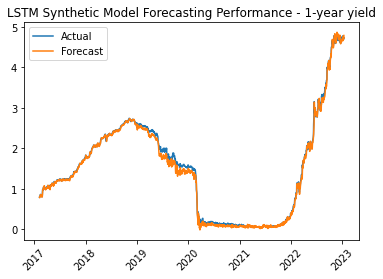

RMSE: 0.11149730970159351
MAPE: 4.511956476978976


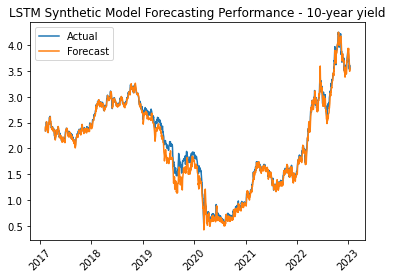

In [35]:
# format dates for comparison
date_compare = test_df['date'].reset_index(drop = True)
date_compare = date_compare[n_steps:].reset_index(drop = True)

# create dataframe for comparing forecasts to actual
LSTM_synth_compare = pd.concat([pd.DataFrame(yhat_synth), pd.DataFrame(test_y)], axis = 1)
LSTM_synth_compare = pd.concat([date_compare, LSTM_synth_compare], axis = 1)
LSTM_synth_compare.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']

# plot results
plot_forecast_compare(LSTM_synth_compare, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = 'LSTM Synthetic Model Forecasting Performance - 1-year yield')

plot_forecast_compare(LSTM_synth_compare, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = 'LSTM Synthetic Model Forecasting Performance - 10-year yield')